# Домашнее задание по теме  
## по теме «Логистическая регрессия»
- EDA(Exploratory Data Analysis) и подготовку данных использовать из 
задания “Классификация SVM”. 

### Импорт библиотек

In [1]:
# Импорт библиотек
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve
                            )
# from eda_tools import get_all_outliers, get_boxplot, get_eda, get_cat_eda, get_correlation_target

In [2]:
# Загрузка файла с данными из архива
archive_path = 'input_data/train_dataset.zip'
with zipfile.ZipFile(archive_path, 'r') as archive:
 
    with archive.open('train_dataset.csv') as file:
        df = pd.read_csv(file)

### Подготовка исходных данных

In [3]:
# Переименование столбцов
df.columns = df.columns.str.replace(r'\(', '_', regex=True)
df.columns = df.columns.str.replace(r'\)', '', regex=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
# df.info(memory_usage=True) # Вывод столбцов и их типов
# df.head() # Вывод "шапки"

In [5]:
# Проверка на дубликаты записей
df_duplicated = df[df.duplicated(keep=False)]
# Количество дублированных строк
duplicated_rows = len(df_duplicated)
df_rows = len(df)
print(f'Всего строк: {df_rows}')
print(f'Дублированных строк: {duplicated_rows}  {duplicated_rows/df_rows:.2%}')

Всего строк: 38984
Дублированных строк: 11034  28.30%


In [6]:
df = df.drop_duplicates()

In [7]:
# df.info(memory_usage=True) 

### Проверка распределения классов целевой переменной

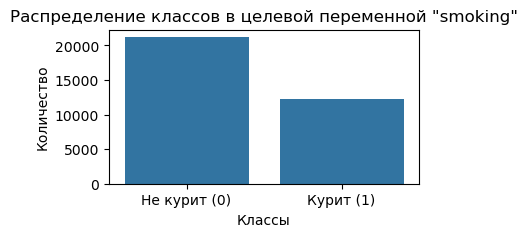

In [8]:
class_counts = df['smoking'].value_counts()

# Создание столбчатой диаграммы
plt.figure(figsize=(4, 2))
sns.barplot(x=class_counts.index, y=class_counts.values)

# Добавление подписей
plt.title('Распределение классов в целевой переменной "smoking"')
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.xticks(ticks=[0, 1], labels=['Не курит (0)', 'Курит (1)'])  # Подписи для оси X
plt.show()

Классы не сбалансированы

### Разделение на выборки

In [9]:
# Разделение данных на признаки (X) и целевую переменную (y)
# X = df.drop(columns=['smoking', 'height_cm', 'waist_cm', 'hearing_left', 'hearing_right', 'eyesight_right', 'eyesight_left', 'weight_kg', 'ast', 'alt'])
X = df.drop(columns=['smoking'])
y = df['smoking']  # Целевая переменная
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Поиск лучших гиперпараметров

In [10]:
param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': np.logspace(-4, 4, 20)  # Параметр регуляризации
    },
    {
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'penalty': ['l2'],
        'C': np.logspace(-4, 4, 20)  # Параметр регуляризации
    }
]

# Создание модели логистической регрессии
log_reg = LogisticRegression(max_iter=1000)

# Поиск лучших гиперпараметров
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'C': 206.913808111479, 'penalty': 'l2', 'solver': 'liblinear'}


### Обучение модели

In [11]:
best_log_reg = LogisticRegression(class_weight='balanced', **best_params, max_iter=1000)
best_log_reg.fit(X_train, y_train)

LogisticRegression(C=206.913808111479, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

### Получение метрик

In [12]:
y_test_pred = best_log_reg.predict(X_test)
y_test_prob = best_log_reg.predict_proba(X_test)[:, 1]

y_train_pred = best_log_reg.predict(X_train)
y_train_prob = best_log_reg.predict_proba(X_train)[:, 1]

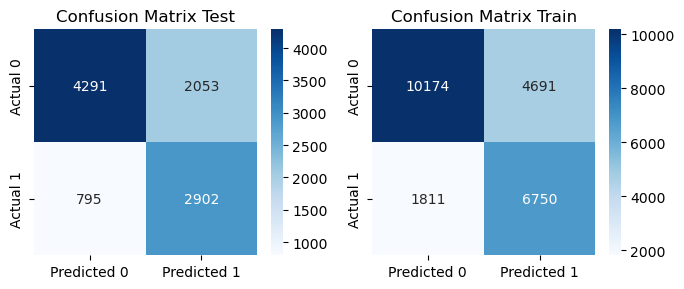

In [13]:
# Confusion Matrix для тестовых данных
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
df_test = pd.DataFrame(conf_matrix_test, 
                      index=['Actual 0', 'Actual 1'], 
                      columns=['Predicted 0', 'Predicted 1'])

# Confusion Matrix для тренировочных данных
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
df_train = pd.DataFrame(conf_matrix_train, 
                        index=['Actual 0', 'Actual 1'], 
                        columns=['Predicted 0', 'Predicted 1'])

fig, axes = plt.subplots(1, 2, figsize=(7, 3)) 

# Confusion Matrix Test
sns.heatmap(df_test, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix Test')

# Confusion Matrix Train
sns.heatmap(df_train, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix Train')

plt.tight_layout()
plt.show()

In [14]:
# print('Confusion matrix test:')
# print(conf_matrix_test)
# print('Confusion matrix train:')
# print(conf_matrix_train)



In [15]:
# Вычисление метрик
metrics = {
    "Accuracy": {
        "test": accuracy_score(y_test, y_test_pred),
        "train": accuracy_score(y_train, y_train_pred),
    },
    "Precision": {
        "test": precision_score(y_test, y_test_pred),
        "train": precision_score(y_train, y_train_pred),
    },
    "Recall": {
        "test": recall_score(y_test, y_test_pred),
        "train": recall_score(y_train, y_train_pred),
    },
    "F1_score": {
        "test": f1_score(y_test, y_test_pred, average='micro'),
        "train": f1_score(y_train, y_train_pred, average='micro'),
    },
    "AUC ROC": {
        "test": roc_auc_score(y_test, y_test_prob),
        "train": roc_auc_score(y_train, y_train_prob),
    },
}
df_metrics = pd.DataFrame(metrics).T
df_metrics = df_metrics.round(4)
df_metrics

,test,train
Accuracy,0.7164,0.7224
Precision,0.5857,0.5900
Recall,0.7850,0.7885
F1_score,0.7164,0.7224
AUC ROC,0.8029,0.8068


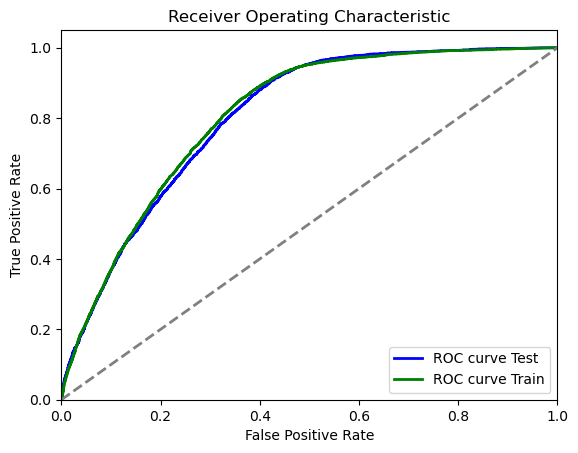

In [16]:
# Построение ROC кривой
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve Test')
fpr, tpr, thresholds = roc_curve(y_train, y_train_prob)
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve Train')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Выводы:
1. Какие значения гиперпараметров алгоритма подойдут для задачи? 
    - Гиперпараметры подобраны с помощью GridSearchCV.
    - Лучшие параметры: {'C': 206.913808111479, 'penalty': 'l2', 'solver': 'liblinear'}  
2. Насколько ваш алгоритм верно предсказывает целевую переменную? 
    - Алгоритм предсказывает с точностью около 72%.
    - Точность предсказания Класса 1 около 59%, из-за не сбалансированности классов.
    
3. Какие критерии качества классификации получились для задачи? 
    - Confusion matrix test:
    [[4291 2053]
    [ 795 2902]]
    
    - Confusion matrix train:
    [[10174  4691]
    [ 1811  6750]]
    
    - Другие метрики
    
| Метрика   |   test |   train |
|-----------|--------|---------|
| Accuracy  | 0.7164 |  0.7224 |
| Precision | 0.5857 |  0.5900 |
| Recall    | 0.7850 |  0.7885 |
| F1_score  | 0.7164 |  0.7224 |
| AUC ROC   | 0.8029 |  0.8068 |

- В целом модель справляется с задачей не хуже алгоритма DecisionTreeClassifier.
- Требуется балансировка классов для повышения точности классификации.